<a href="https://colab.research.google.com/github/abuebayyeh/imperial_eee_machine_learning_course/blob/main/06_ML_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVMs)


---
In your previous exploration, you delved into the utilisation of the perceptron algorithm for binary classification, where the primary goal was to identify a decision boundary that effectively separates two distinct classes.  If you take a look on the figure below, you can find that each line (or hyperplane if we are dealing with higher dimensions) is satisfying the perceptron's requirements by separating the two classes.

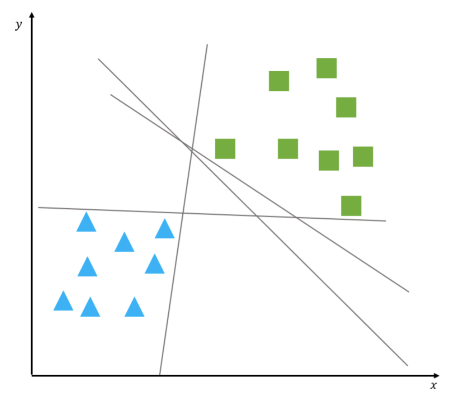

Despite their effectiveness, a pertinent question arises: amidst these decision boundaries, is there one that outperforms the rest? This query leads us to the realm of Support Vector Machines (SVMs), an influential machine learning technique tailored for binary classification tasks.

At its core, SVM operates as a powerful algorithm with the explicit purpose of discovering an ideal hyperplane. It moves beyond mere separation, placing heightened emphasis on the pivotal task of maximizing the margin between the two classes within a dataset as shown in the figure below.

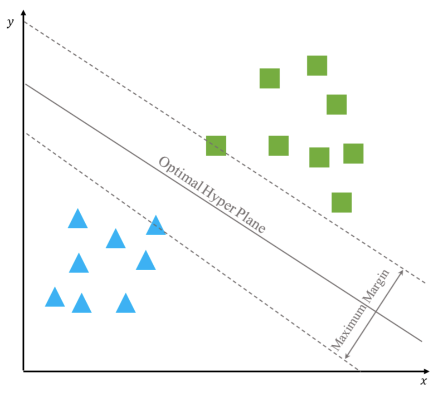


# Hard Margin SVM



## 1. Objective Function

In the context of hard-margin SVM, the aim is to determine a hyper-plane characterised by a weight vector $\mathbf{W}$ and a bias $\mathbf{b}$. The objective function is formulated as:

$$
\text{Minimise} \quad \frac{1}{2} \| \mathbf{W} \|_2^2
$$

This function represents the squared Euclidean norm of the weight vector $\mathbf{W}$, quantifying the margin.

## 2. Margin Constraints

The hard-margin SVM enforces specific constraints to guarantee accurate classification of each data point. For a dataset containing $m$ instances, these constraints are expressed as:

$$
y_i (\mathbf{X}_i \cdot \mathbf{W} + b) \geq 1 \quad \text{for } i = 1, 2, \ldots, m
$$

Here, $\mathbf{X}_i$ represents the feature vector of the *i*-th instance, and $\mathbf{y}_i$ is its associated class label (+1 or -1).

## 3. Lagrange Multipliers

Lagrange multipliers (dual variables) are introduced to transform the constrained optimisation problem into an unconstrained one. Let $\mathbf{\alpha}_i$ be the Lagrange multiplier linked to the *i*-th constraint. The Lagrangian $\mathbf{L}$ is formulated as:

$$
L(\mathbf{W}, b, \boldsymbol{\alpha}) = \frac{1}{2} \| \mathbf{W} \|_2^2 + \sum_{i=1}^m \alpha_i \left( 1 - y_i (\mathbf{X}_i \cdot \mathbf{W} + b) \right)
$$

The dual problem involves maximizing the Lagrangian with respect to the Lagrange multipliers $\mathbf{\alpha}_i$:

$$
\text{Maximise} \quad L(\mathbf{W}, b, \boldsymbol{\alpha})
$$

Subject to the constraint $\mathbf{\alpha}_i$ ≥ 0 for all *i* (since the Lagrange multipliers are non-negative).

## 4. Solving the Dual Problem

The dual problem is a maximization problem involving the Lagrangian. To solve it, we compute the derivative of $\mathbf{L}$ with respect to $\mathbf{W}$ and $\mathbf{b}$, set these derivatives to zero, and substitute the results back into the Lagrangian. This process leads to a dual optimisation problem involving only the Lagrange multipliers $\mathbf{\alpha}_i$.

Solving the dual problem yields the optimal values of $\mathbf{\alpha}$. The instances corresponding to non-zero $\mathbf{\alpha}_i$ values are the support vectors. The decision boundary is expressed using the support vectors and the Lagrange multipliers.

## 5. Constructing the Decision Boundary

Once the optimal Lagrange multipliers $\mathbf{\alpha}$ are obtained, the decision boundary can be constructed using the support vectors. The weight vector $\mathbf{W}^*$ is computed as a linear combination of the support vectors:

$$
\mathbf{W}^* = \sum_{i=1}^m \alpha_i y_i \mathbf{X}_i
$$

The bias $\mathbf{b}$ can be determined using:

$$
b = \frac{1}{y_i} - \mathbf{X}_i \cdot \mathbf{W}^*
$$


In summary, the hard-margin SVM involves formulating the SVM problem with an objective function and margin constraints, introducing Lagrange multipliers to transform the problem, solving the dual optimisation problem, and then using the obtained Lagrange multipliers to construct the decision boundary and make predictions.

The provided code aligns with this theoretical framework by formulating the SVM optimisation problem, solving it using `cvxpy`, and visualising the results. More information about using the library `cvxpy` can be found [here](https://www.cvxpy.org/)

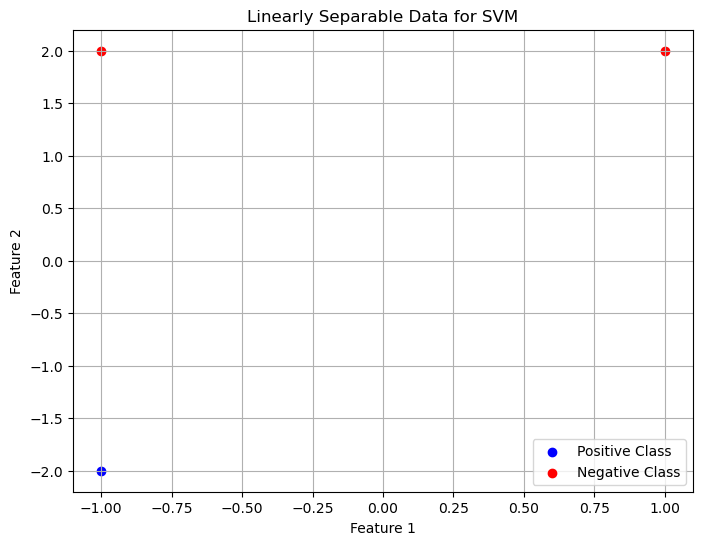

In [12]:
# Create linearly separable data

import numpy as np
import matplotlib.pyplot as plt

# Generate positive class samples
X_positive = np.array([[-1, -2]])
y_positive = np.ones(len(X_positive))

# Generate negative class samples
X_negative = np.array([[1,2],[-1,2]])
y_negative = -np.ones(len(X_negative))

# Concatenate positive and negative samples
X = np.vstack((X_positive, X_negative))
y = np.concatenate((y_positive, y_negative))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='o', label='Positive Class', color='blue')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], marker='o', label='Negative Class', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Data for SVM')
plt.legend()
plt.grid()
plt.show()

In [13]:
import cvxpy as cp


def hard_margin(X, y):
    m, n = X.shape

    # Define the SVM optimization problem
    W = cp.Variable(n, value=np.zeros(n))  # Weights
    b = cp.Variable(value=0)               # Bias
    objective = cp.Minimize(0.5 * cp.square(cp.norm(W)))
    constraints = [y[i] * (X[i] @ W + b)  >= 1 for i in range(m)]  # Margin constraints

    # Formulate and solve the SVM problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Check if the problem was solved successfully
    if prob.status != cp.OPTIMAL:
        print("SVM optimization failed. Please check the data and constraints.")
        return

    # Get the optimal values of W and b
    W_optimal = W.value
    b_optimal = b.value
    print("Optimal value of W:", W_optimal)
    print("Optimal value of b:", b_optimal)

    # Calculate the slope and intercept of the decision boundary
    slope = -W_optimal[0] / W_optimal[1]
    intercept = -b_optimal / W_optimal[1]

    # Calculate the support vectors
    alphas = np.array([constraints[i].dual_value for i in range(m)])  # Extract alphas corresponding to support vectors
    non_zero_alphas = alphas[np.where(alphas > 1e-4)] # Due to approximations you may get too small values for alpha instead of zero. We will consider values below 1e-4 as zero for alpha.
    support_vectors = X[np.where(alphas > 1e-4)]  # Choose support vectors with non-zero dual values
    #print(alphas)
    print("Non_zero aplhas:", non_zero_alphas)
    print("Support Vectors:\n", support_vectors)


    # Plot the data points and decision boundary
    #plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    x_vals = np.array([np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1])
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, label='Decision Boundary', color='black')

    # Plot the support vectors
    margin = 1 / W_optimal[1]
    y_down = y_vals - margin
    y_up = y_vals + margin
    plt.plot(x_vals, y_down, linestyle='dotted', color='grey')
    plt.plot(x_vals, y_up, linestyle='dotted', color='grey')
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, facecolors='none', edgecolors='r', label='Support Vectors')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.grid()
    plt.show()

Optimal value of W: [-1.42639675e-05 -5.00000002e-01]
Optimal value of b: -1.4263967754532044e-05
Non_zero aplhas: [0.12499999 0.12498264]
Support Vectors:
 [[-1 -2]
 [-1  2]]


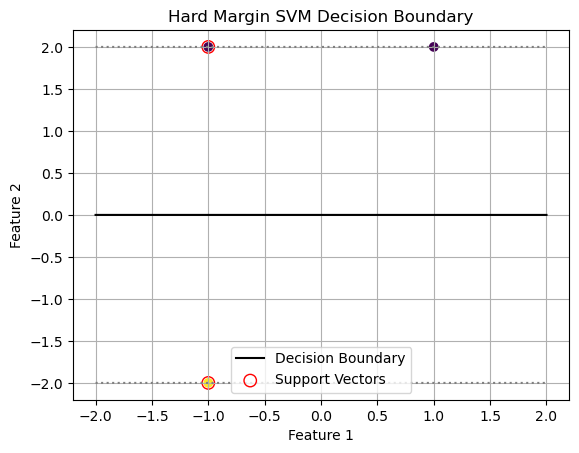

In [14]:
hard_margin(X, y)

## Task 1 [10 marks]

In this task, you will compare the outcomes you calculated in **Question 1** with the results obtained from the provided hard-margin SVM function when applied to the same dataset.


1. **Review Question 1:**
   Begin by revisiting the results you obtained in **Question 1**. Remind yourself of the Lagrange multipliers ($\boldsymbol{\alpha}$) you calculated and the support vectors you identified manually.

2. **Utilise the Provided Code:**
   Next, employ the provided hard-margin SVM function to train an SVM classifier on the same dataset. The function will automatically determine the optimal parameters and pinpoint the support vectors.

3. **Generate a Visualisation:**
   Create a plot that displays the dataset's data points, the decision boundary, margins, and the support vectors. This visual representation will help you comprehend how the SVM separates the classes.

4. **Compare and Analyze:**
   Compare the ($\boldsymbol{\alpha}$) values calculated in **Question 1** with the dual values obtained using the SVM function. Additionally, pay attention to the support vectors identified through both manual calculations and the `hard_margin` function. Reflect on the similarities (and differences if any) you observe between the two sets of results.

5. **Document Your Observations:**
   Summarise your findings and reflections concerning the discrepancies and agreements between your manual calculations and the SVM function's outcomes. Discuss any insights you've gained into the SVM's decision-making process and the alignment of your manual work with the code approach.

6. **Include the Plot:**
   Embed the generated plot in your documentation that show the data along with the decision boundary, margins, and support vectors.




In [15]:
# Task 1



# Soft Margin SVM

The soft margin SVM extends this adaptability by introducing a flexible approach that accommodates instances that may not adhere strictly to class boundaries.

## 1. Soft Margin SVM Objective

In the context of the soft margin SVM, the objective shifts from aiming for perfect separation to achieving a balance between maximizing the margin and allowing some instances to relax their adherence to strict classification boundaries. This equilibrium is controlled by the hyper-parameter $ C $. The objective function is designed as:

$$
\text{Minimise} \quad \frac{1}{2} \| \mathbf{W} \|_2^2 + C \sum_{i=1}^{m} \xi_i
$$

Here, $ C $ regulates the trade-off between expanding the margin and allowing instances to ease their strict classification.

## 2. Margin Constraints and Flexibility

The constraints in the soft margin SVM introduce a "relaxing corridor" for instances. This acknowledges that not all instances can be perfectly classified, and thus, non-negative slack variables $ \xi_i $ are introduced to accommodate instances that may not strictly satisfy the margin conditions. The margin constraints are expressed as:

$$
y_i (\mathbf{X}_i \cdot \mathbf{W} + b) \geq 1 - \xi_i \quad \text{for } i = 1, 2, \ldots, m
$$

These constraints allow instances to move slightly inside the margin or even on the wrong side of the decision boundary, with a penalty proportional to $ \xi_i $.

## 3. Lagrange Multipliers and Dual Problem

As in the hard-margin case, Lagrange multipliers $ \alpha_i $ are introduced to transform the optimization problem. The Lagrangian for the soft margin SVM incorporates the slack variables and is given by:

$$
L(\mathbf{W}, b, \boldsymbol{\alpha}, \boldsymbol{\xi}, \boldsymbol{\beta}) = \frac{1}{2} \| \mathbf{W} \|_2^2 + C \sum_{i=1}^{m} \xi_i + \sum_{i=1}^{m} \alpha_i \left(1 - \xi_i - y_i (\mathbf{X}_i \cdot \mathbf{W} + b)\right) - \sum_{i=1}^{m} \beta_i \xi_i
$$

The dual problem remains focused on maximizing the Lagrangian subject to the constraint $ \alpha_i \geq 0 $.

## 4. Solving the Dual Problem

Solving the dual problem involves finding optimal Lagrange multipliers $ \alpha_i $ and slack variables $ \xi_i $ that adhere to the Karush-Kuhn-Tucker (KKT) conditions. The instances corresponding to non-zero $ \alpha_i $ values are the support vectors that actively influence the decision boundary.

## 5. Constructing the Decision Boundary

Once optimal Lagrange multipliers $ \alpha_i $ are determined, the construction of the decision boundary remains similar to the hard-margin SVM. The weight vector $ \mathbf{W}^* $ is calculated using the support vectors:

$$
\mathbf{W}^* = \sum_{i=1}^{m} \alpha_i y_i \mathbf{X}_i
$$

The bias $\mathbf{b}$ can be determined using:

$$
b = \frac{1}{y_i} - \mathbf{X}_i \cdot \mathbf{W}^*
$$

In conclusion, the soft margin SVM introduces a balanced approach, allowing instances some flexibility in adhering to strict classification boundaries. The hyper-parameter $ C $ guides this balance, offering adaptability to real-world scenarios.

## Task 2 [60 marks]

In this task, you will modify the provided hard-margin SVM code to implement a soft-margin SVM. Additionally, you will explore the impact of different values of the regularization parameter `C` on the results.

1. **Load the Dataset:**
   Use the same dataset form the first code cell.

2. **Modify the Code:** Take the hard-margin SVM code provided and modify it to implement a soft-margin SVM. The new function can be named `soft_margin` and will accept `(X,y,C)` as inputs to the function.

3. **Parameter Exploration:** Use a range of `C` values: `[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]`. For each value of `C`, train the soft-margin SVM on the same dataset and observe the results.

4. **Observations and Analysis:** For each value of `C`, compare and analyze the following aspects:
   - The decision boundary and the positions of the support vectors.
   - The number of support vectors.
   - The impact on the margin width.

5. **Documentation:** Create a summary report that includes the modified code, the results obtained for each `C` value (optimal $\mathbf{W}$ and $\mathbf{b}$ values and a plot that shows data along with margins and support vectors ), and your observations and analysis. Discuss how changing the value of `C` affects the trade-off between achieving a wider margin and allowing some misclassifications.

6. **Conclusion:** Based on your observations and analysis, conclude which values of `C` appear to work best for the given dataset and explain your reasoning.


In [16]:
# Task 2



# Scikit-learn Implementation

If you're looking to apply SVM to your data using Python, scikit-learn provides a convenient and user-friendly way to do so. First, you'll need to import the necessary module:
```python
from sklearn.svm import SVC
```

You can initialise the classifier with various parameters:
> More information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)



## Task 3 [30 marks]



In this task, you will implement both the soft-margin and hard-margin Support Vector Machine (SVM) representations using the scikit-learn library for the same dataset. You will document your code, generate plots to visualise the decision boundaries, margins, and support vectors, and extract the optimal values of ($\mathbf{W}$) and $\mathbf{b}$.


1. **Load the Dataset:**
   Use the same dataset form the first code cell.

2. **Implement Soft-Margin SVM:**
   Using the scikit-learn library, implement the soft-margin SVM. Utilise a loop to train SVM classifiers with varying values as in Task 2. For each \( C \) value, document the optimal ($\mathbf{W}$) and $\mathbf{b}$ values obtained from the SVM model.

3. **Visualise Soft-Margin SVM:**
   Generate plots for each \( C \) value to visualise the dataset, decision boundary, margins, and support vectors. These plots will help you comprehend the impact of different \( C \) values on the SVM representation.

4. **Implement Hard-Margin SVM:**
   Repeat the process for the hard-margin SVM. Train SVM classifiers using the scikit-learn library. Document the optimal \($\mathbf{W}$) and $\mathbf{b}$ value for each case.

5. **Visualise Hard-Margin SVM:**
   Create plot similar to the soft-margin SVM case to visualise the hard-margin SVM result.

6. **Documentation:**
   Document your code, including how you loaded the data, implemented the SVM classifiers, and extracted the optimal parameters. Embed the generated plots in your documentation.

7. **Summarise Observations:**
   Summarise your observations on the differences between soft-margin and hard-margin SVM implementation form scikitlearn perspective.

.


In [17]:
# Task 3 (soft margin)



In [18]:
# Task 3 (hard margin)
